### IMPORTANT: Please check the utils_cat_dogs.py module to see relevant functions for each model and process. My main purpose is to use the notebook files for result demonstration.

## **Author**: *Sena Nur Bilgin*
## **Specialization**:  *DSA*
## **Subject**: *Assignment 2 - Image-Classification*

#### **Dataset Description:**

*The training archive consists of 25,000 images categorized into dogs and cats.*

- `1` denotes a **dog**.
- `0` denotes a **cat**.

*Upon running the CNN model, you will encounter the following dataset values:*

- **20,000** *validated image filenames belonging to **2 classes**.*
- **2,500** *validated image filenames belonging to **2 classes**.*
- **2,500** *validated image filenames belonging to **2 classes**.*


#### ***Dataset Link**: *[Dogs vs. Cats Dataset on Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data)*


*This dataset is commonly used for image classification tasks in machine learning and deep learning. The goal typically involves training a model to accurately classify images as either dogs or cats based on the training data provided.*


<a name="1"></a>
## 1 - Packages & Module Calls

*To begin, import the necessary Python packages and modules for the data analysis and machine learning tasks. In this section, we ensure all dependencies are loaded and ready to use.*



In [1]:
%load_ext autoreload
%autoreload 2

<a name="2"></a>
## 2 - Paths & Data 

*To begin, import the necessary Python packages and modules for the data analysis and machine learning tasks. In this section, we ensure all dependencies are loaded and ready to use.*



In [2]:
import numpy as np
import pandas as pd
import sys
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from joblib import dump 
sys.path.append("..")
from utils_cat_dogs import *


<a name="2"></a>
## 3 - Models

<a name="1"></a>
## (A) - Custom CNN for Image Classification (Dogs-Cats)
### Process Descriptions Before Running the Model :



### (1) Loading Data - CNN 

**load_data(train_path, test_path) function:** 

*It aims to facilitate the loading and preprocessing of image filenames and their corresponding labels from specified directories (train_path and test_path) where my datasets are located. Initially, it reads all filenames from train_path, extracts labels assuming filenames are structured as label.filename.ext, and constructs a DataFrame data_train containing filenames and labels. Then, it splits data_train into training (X_train) and temporary (X_temp) sets using train_test_split, ensuring stratification based on train_labels to maintain class distribution. From X_temp, it further splits into testing (X_test) and validation (X_val) sets using another train_test_split, stratifying based on label_test_val, ensuring balanced class representation in both sets. Finally, it returns X_train, X_val, and X_test, DataFrames containing the split datasets for training, validation, and testing purposes in a machine learning pipeline.*




### (2) Setting Generator Configurations

**setup_generators(train_df, val_df, test_df, train_dir, image_size, batch_size) function:**

**Data Loading and Augmentation Phase:** *Here, we are applying ImageDataGenerator Configurations.*

- **train_datagen:** *Configures an `ImageDataGenerator` for the training data with various data augmentation techniques such as rotation, horizontal flip, zoom, shear, and shift. These augmentations help the model generalize better by exposing it to variations of the input data.*

- **test_datagen:** *Configures an `ImageDataGenerator` for the validation and testing data with only rescaling (`1./255`), ensuring that the input data is scaled consistently across all phases without altering its content.*

- **train_generator:** *Uses `train_datagen.flow_from_dataframe` to generate batches of augmented training data. It reads image filenames and their corresponding labels from the `train_df` DataFrame, loads images from `train_dir`, applies specified augmentations, resizes them to `image_size`, and yields batches of augmented images along with their labels (`'label'` column).*

- **val_generator:** *Similar to `train_generator`, but for validation data. It ensures that the validation data undergoes consistent preprocessing and augmentation steps, facilitating accurate evaluation of the model's performance during training.*

- **test_generator:** *Similar to `val_generator`, but for testing data. It prepares the testing data in the same manner as validation data, ensuring that model evaluation on unseen data is fair and unbiased.*

*Overall, to provide efficient data handling, I have been using `ImageDataGenerators`. The function streamlines the process of loading, preprocessing, and augmenting image data. I wanted to ensure that all images are uniformly resized and supplemented according to the specified parameters (`image_size`, augmentation settings) across different phases of the model pipeline (training, validation, testing).Here, Data augmentation introduces variability into the training data via augmentations, which helps the model generalize better and improves its robustness to unseen variations. Additionally, by introducing batch processing, I have generated batches of data (`batch_size`) during model training, which is memory-efficient and allows models to be trained on datasets larger than available RAM. In sum, the `setup_generators` function is critical in preparing image data for deep learning tasks by configuring `ImageDataGenerators` to handle preprocessing, augmentation, and batch generation. This ensures that the model is trained, validated, and tested on properly formatted data conducive to achieving accurate and reliable performance metrics.*


### (3) Model Architecture

*In sequential modeling, I am initializing a model where all layers are added sequentially.*

##### CNN Layers & Blocks:
- **Input Layer**: *Here, I added an input layer which begins with a `Conv2D` layer with 32 filters of size `(3, 3)`, using ReLU activation, and expects input images of shape `(image_size, image_size, image_channel)`. This layer extracts preliminary features from input images.*
- **CNN Filter Blocks (1-3)**: *There are successive sets of `Conv2D`, `BatchNormalization`, `MaxPooling2D`, and `Dropout` layers. Each block increases the number of filters (`64`, `128`, `256`) to capture increasingly complex patterns in the data. I determined these parameters as optimal features after extensive evaluation. I did not apply cross-validation in this step due to limited RAM and GPU resources.*

#### Applied Parameters to Improve CNN Filter Blocks Performance:
- **Batch Normalization**: *Applied after each `Conv2D` layer to improve convergence speed and generalization.*
- **MaxPooling2D**: *Reduces spatial dimensions (width and height) of the feature maps extracted by `Conv2D`.* 
- **Dropout**: *Prevents overfitting by randomly setting a fraction (`0.2` in this case) of input units to zero during training. I opted for this regularization to strike a balance and not limit the model with higher regularization parameters.*

#### Fully Connected Layers:
- **Flatten Layer**: *As we covered during the course, flatten layers reduce the 2D feature maps into a 1D vector, preparing them for input into fully connected (dense) layers.* 
- **Dense Layers**: *The model consists of a `Dense` layer with `512` units and ReLU activation, followed by `BatchNormalization` and `Dropout`. These layers learn high-level features from the flattened feature vectors.* 
- **Dense Output Layer**: *Outputs a softmax activation with `2` units, suitable for binary classification tasks. It outputs probabilities for each class (`0` and `1`).*

**Model Compilation - Preparing CNN for Training:** *I have configured the model for training using the `Adam` optimizer, `binary_crossentropy` loss function (suitable for binary classification), and `accuracy` metric to monitor model performance during training. The `define_model` function constructs a CNN architecture tailored for image classification by sequentially adding convolutional, pooling, dropout, normalization, and dense layers. It aims to effectively learn and generalize patterns from image data while mitigating overfitting through regularization techniques.*


### (4) Training the Model

*The `train_model` function trains a given Keras model using the provided data generators for training and validation. I take multiple parameters which I am going to discuss now.*

*First I have set up two important callbacks, `ReduceLROnPlateau` and `EarlyStopping`, to enhance the training process of a Keras model. Here, `ReduceLROnPlateau` monitors the validation accuracy and reduces the learning rate by a factor of 0.5 if it does not improve for `2 consecutive epochs`, ensuring `the learning rate does not fall below 0.00001`. This adjustment helps in navigating through plateaus during training. `By introducing EarlyStopping`, I am monitoring the validation loss and stopping the training `if there is no improvement for 3 consecutive epochs`, restoring the `best model` weights observed during training.I combined these callbacks are combined into a list and passed to the train_model function, which trains the model using the specified training and validation data generators for a given number of epochs. The callbacks help me to dynamically adjust the learning rate and prevent overfitting by stopping the training early, making the training process more efficient and effective. The history object returned by train_model provides a detailed log of the training metrics across epochs, facilitating performance analysis.*


Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Epoch 1/30


2024-06-15 10:36:45.627429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-15 10:36:45.658688: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


625/625 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.6701

2024-06-15 10:39:52.279690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 193s 308ms/step - loss: 0.6501 - accuracy: 0.6701 - val_loss: 0.6940 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 204s 326ms/step - loss: 0.5067 - accuracy: 0.7541 - val_loss: 0.4993 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 193s 308ms/step - loss: 0.4463 - accuracy: 0.7926 - val_loss: 0.8142 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 198s 316ms/step - loss: 0.3814 - accuracy: 0.8296 - val_loss: 0.3723 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 193s 309ms/step - loss: 0.3401 - accuracy: 0.8492 - val_loss: 0.3582 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 192s 307ms/step - loss: 0.3153 - accuracy: 0.8582 - val_loss: 0.2957 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 199

2024-06-15 12:11:39.460635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


The accuracy of the model for training data is: 96.96499705314636
The Loss of the model for training data is: 0.0813194140791893


2024-06-15 12:12:56.266970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


The accuracy of the model for validation data is: 94.55999732017517
The Loss of the model for validation data is: 0.13573992252349854


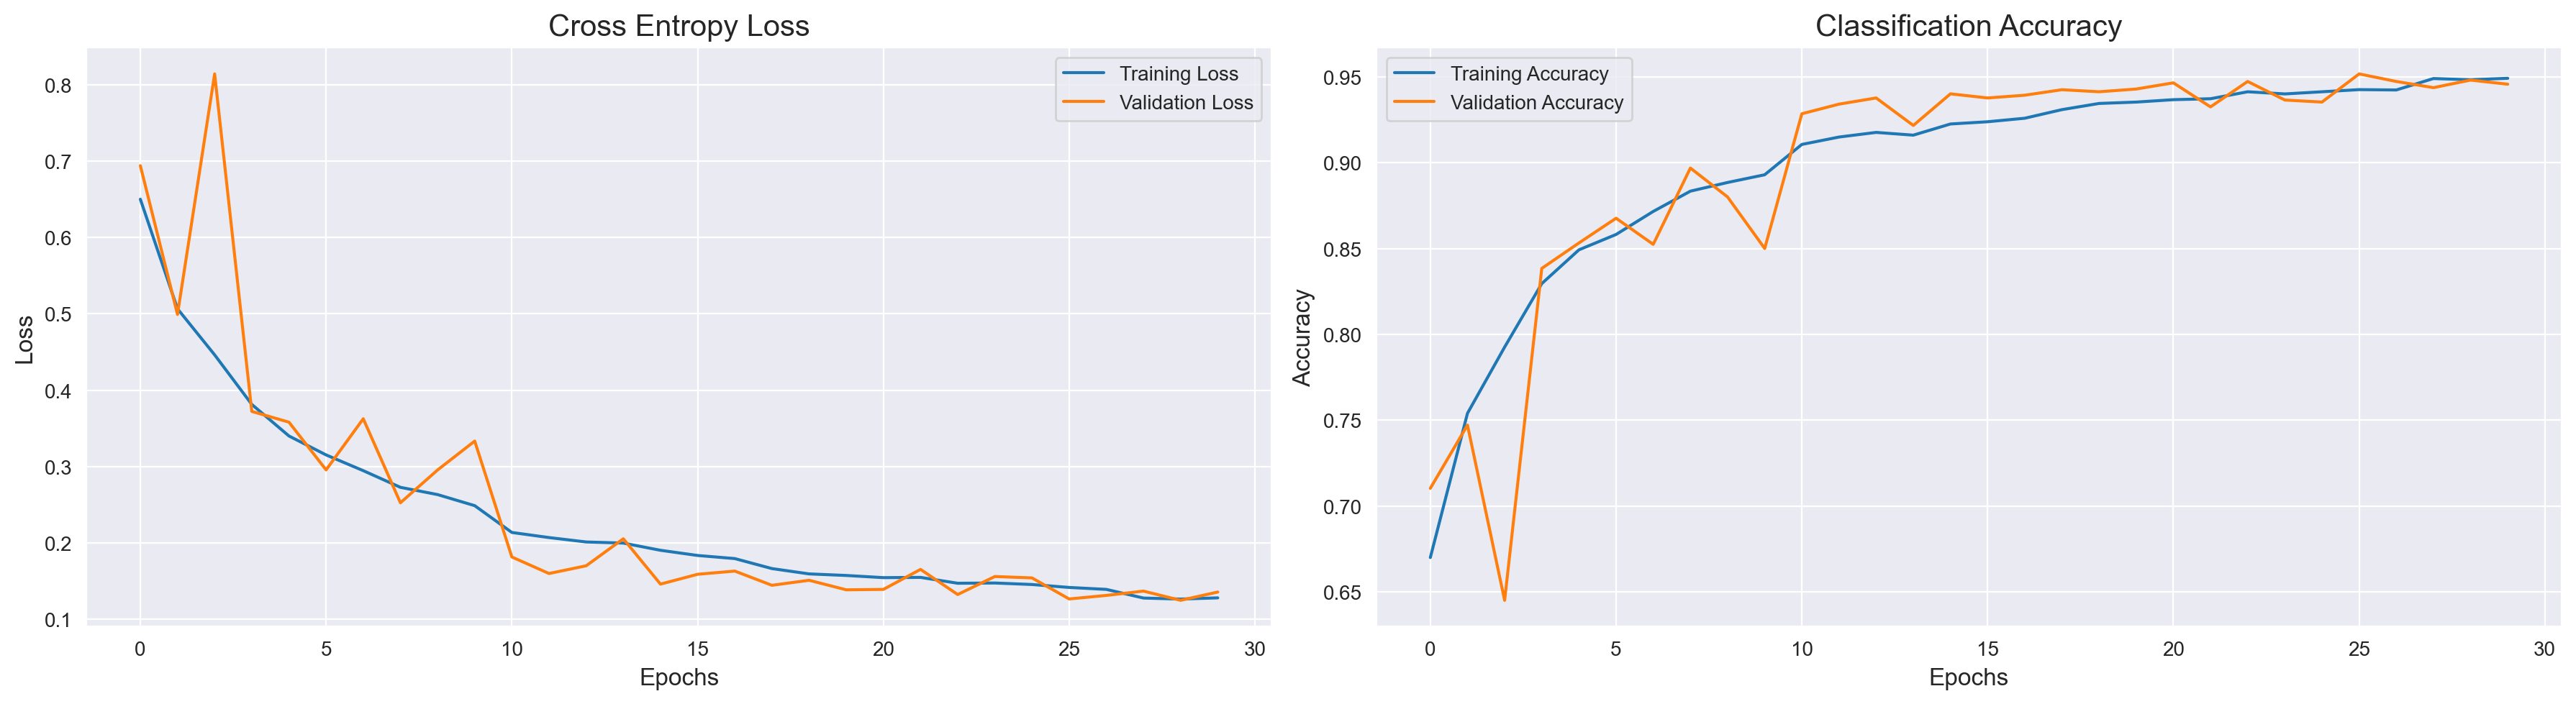

In [4]:
TRAIN_PATH = "../Data/dogs-vs-cats/train"
TEST_PATH = "../Data/dogs-vs-cats/test"
IMAGE_SIZE = 128
IMAGE_CHANNEL = 3
BATCH_SIZE = 32
N_EPOCH = 30

X_train, X_val, X_test = load_data(TRAIN_PATH, TEST_PATH)

train_generator, val_generator, test_generator = setup_generators(X_train, X_val, X_test, TRAIN_PATH, IMAGE_SIZE, BATCH_SIZE)

model = define_model(IMAGE_SIZE, IMAGE_CHANNEL)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

callbacks = [learning_rate_reduction, early_stopping]

history = train_model(model, train_generator, val_generator, N_EPOCH, callbacks)

train_loss, train_acc = evaluate_model(model, train_generator, BATCH_SIZE)
print('The accuracy of the model for training data is:', train_acc * 100)
print('The Loss of the model for training data is:', train_loss)

val_loss, val_acc = evaluate_model(model, val_generator, BATCH_SIZE)
print('The accuracy of the model for validation data is:', val_acc * 100)
print('The Loss of the model for validation data is:', val_loss)

plot_training_history(history)
model_save_path = '../Models/best_cnn_model_image.h5'  # Specify where to save the model
save_model(model, model_save_path)

 **Results:** *The results from training the convolutional neural network (CNN) model demonstrate its effectiveness in learning to classify images. Throughout the 30 epochs of training, the model improved its performance, achieving a high training accuracy of 96.96% with a correspondingly low training loss of 0.0813. This indicates that the model has successfully learned to classify the training images with a high degree of accuracy and precision. During validation, the model maintained a strong performance, achieving a validation accuracy of 94.56% and a validation loss of 0.1357 by the end of training. These metrics suggest that the model generalizes well to unseen data, as evidenced by the close alignment of validation performance with training performance. This phenomena is indicated by closing gap between the lines. The use of learning rate adjustments via ReduceLROnPlateau helped optimize the training process, ensuring the model converged efficiently without overfitting.*

### (5) Evaluation of Model Performance

**`evaluate_model(model, generator, batch_size) function:`**:

*Here, I am utilizing the `evaluate_model` function to assess the performance of a trained Keras model using a specified data generator. The main purpose is evaluating the model's generalization on unseen data after it has been trained. I have multiple parameters to pass to the functions which are `generator`: is important to provides batches of data for evaluation; `batch_size` for specifying how many samples are processed before the model's internal parameters are updated during training or evaluation. Later, I computed the loss and accuracy on the provided evaluation dataset, which is generated batch by batch from `generator`.*

*The function returns two values: **`loss`**: The computed loss value of the model on the evaluation dataset. This indicates how well the model's predictions match the actual labels. **`acc`**: The computed accuracy of the model on the evaluation dataset. Accuracy measures the proportion of correctly predicted samples out of the total number of samples.*

In [12]:
loss, acc = evaluate_model(model, test_generator, BATCH_SIZE)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc*100:.2f}%")



Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


2024-06-15 16:32:54.955269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-15 16:32:54.991951: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Test Loss: 0.1375
Test Accuracy: 94.24%


**Regarding the output of CNN model evaluation:** 

**Test Loss:** *The test loss value (0.1375) indicates the average loss across all test samples. Lower values indicate better performance of the model in terms of predicting the correct class probabilities.* **Test Accuracy:** *The test accuracy (94.24%) represents the percentage of correctly predicted labels out of all test samples In summary, the CNN model achieved a test loss of 0.1375, which suggests that on average, the predictions are close to the actual labels. The test accuracy of 94.24% indicates that the model performed well in classifying images correctly on the test dataset.*

<a name="2"></a>
## 4 - Overall Conclusion


*In my analysis, the CNN architecture designed for complex image classification is built to extract deeper features essential for extracting detailed patterns within images. This architecture includes multiple convolutional layers with increasing filter sizes (32, 64, 128, 256), along with techniques like batch normalization, dropout, and max-pooling. Tuning this model proved challenging compared to the simpler Digit Classification CNN architecture, requiring extensive experimentation to balance model complexity and performance.*

*Conversely, the Digit Classification CNN architecture prioritizes simplicity and efficiency for accurately recognizing digits from images. It features fewer convolutional layers with customizable filter numbers, emphasizing compactness and computational efficiency. This streamlined approach facilitates quicker training times and more straightforward parameter optimization compared to the complex image classification task.*

*Throughout my experiments, I tried, at first hand, grid search to systematically explore and optimize hyperparameters for both CNN architectures. While grid search efficiently identified optimal parameters for digit classification, the process was more difficult for complex image classification due to the deeper architecture and greater sensitivity to parameter settings. This complexity necessitated longer training times and careful adjustment of parameters like learning rates and batch sizes to achieve satisfactory convergence. Therefore, I have come up with a CNN model without hyperparameter tuning. I have also try to train logistic regression, however, it didnt work.  I have excluded all analysis, Sorry for that..*

*To summarize, the CNN architectures excelled in both tasks, achieving high accuracies between 94% to 98% with minimal loss. Despite their effectiveness, each task presented unique challenges and required distinct optimizations. The digit classification task benefited from simpler architectures and straightforward parameter tuning, leading to efficient model training and high performance. In contrast, the complex image classification task demanded deeper architectures and rigid parameter adjustments to handle image data processing. It's worth noting that while I applied the same CNN model structure with varying architectural parameters across tasks, adapting to different data types posed additional challenges. The digit dataset was straightforward, consisting of numerical representations, whereas the complex image dataset required preprocessing to reduce images into array dimensions suitable for CNN processing. These observations of mine highlight the overall successes of CNN architectures across different tasks while emphasizing the importance of adapting models and parameters to specific data characteristics for optimal performance and efficiency.*